In [1]:
import win32com.client as com
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
## Connecting the COM Server => Open a new Vissim Window:
Vissim = com.Dispatch("Vissim.Vissim")


In [5]:
# Loads the VISSIM file and opens it
# Locat path where the file is
Vissim.LoadNet(r'C:\Users\chase\Documents\vissimpark\VISSIM_configs\VISSIM August\Scenario 1\SLU-fnl-baseline.inpx')
Vissim.LoadLayout(r'C:\Users\chase\Documents\vissimpark\VISSIM_configs\VISSIM August\Scenario 1\SLU-fnl-baseline.layx' )

In [6]:
# Delete all previous simulation runs first:
for simRun in Vissim.Net.SimulationRuns:
    Vissim.Net.SimulationRuns.RemoveSimulationRun(simRun)

In [7]:
for cnt_Sim in range(1):
    Vissim.Simulation.SetAttValue('RandSeed', cnt_Sim + 1) # Note: RandSeed 0 is not allowed
    Vissim.Simulation.RunContinuous()

Vissim.ResumeUpdateGUI(True); # allow updating of the complete Vissim workspace (network editor, list, chart and signal time table windows)
Vissim.Graphics.CurrentNetworkWindow.SetAttValue("QuickMode",1) # activate QuickMode

In [18]:
# List of all Simulation runs:
Attributes      = ['Timestamp', 'RandSeed', 'SimEnd']
number_of_runs  = Vissim.Net.SimulationRuns.Count
List_Sim_Runs   = Vissim.Net.SimulationRuns.GetMultipleAttributes(Attributes)
for cnt_S in range(number_of_runs):
    print( '%s | %d | %d ' % (List_Sim_Runs[cnt_S][0], List_Sim_Runs[cnt_S][1], List_Sim_Runs[cnt_S][2]))


2021-08-11 07:38:32 | 1 | 10800 


In [21]:
## ========================================================================
# Results of Simulations:
#==========================================================================
# from data collection points
No_Veh = []
Speed = []
Acceleration = []
Occupancy = []
dc=[]
time=[]
sim_run_list=[]
# Data Collection
num_dp = 4

### these need to be aggregated for 2 lane measurementss
dc_measurements = list(range(1,48)) # one lane measurements

for DC_measurement_number in dc_measurements:

    DC_measurement = Vissim.Net.DataCollectionMeasurements.ItemByKey(DC_measurement_number)
# Syntax to get the data:
#   DC_measurement.AttValue('Vehs(sub_attribut_1, sub_attribut_2, sub_attribut_3)')
#
# sub_attribut_1: SimulationRun (same as described at Vehicle Travel Time Measurements)
# sub_attribut_2: TimeInterval  (same as described at Vehicle Travel Time Measurements)
# sub_attribut_3: VehicleClass  (same as described at Vehicle Travel Time Measurements)
#
# The value of on time interval is the arithmetic mean of all single values of the vehicles.

# Example #1:
# Average value of all simulations (1. input = Avg)
# 	of the 1st time interval (2. input = 1)
#   of all vehicle classes (3. input = All)
    for sim_run in range(1,2):  # change the number of simulation runs as fit
        for time_int in range(1,166):
            vehicle_str = 'Vehs        ('+str(sim_run) +','+ str(time_int) + ',All)'
            speed_str = 'Speed        ('+str(sim_run) +','+ str(time_int) + ',All)'
            
            #print(speed_str)
            sim_run_list.append(sim_run)
            dc.append(DC_measurement_number)
            time.append(time_int)
            No_Veh.append(DC_measurement.AttValue(vehicle_str)) # number of vehicles
            Speed.append(DC_measurement.AttValue(speed_str)) # Speed of vehicles

            
df = pd.DataFrame(list(zip(time, dc, sim_run_list, No_Veh, Speed )),
               columns =['Time', 'Data_Measurement','Sim_Run', 'No_Veh', 'Speed'])


In [22]:
df = pd.DataFrame(list(zip(time, dc, sim_run_list, No_Veh, Speed )),
               columns =['Time', 'Data_Measurement','Sim_Run', 'No_Veh', 'Speed'])

In [23]:
df.to_csv("parking_rate_30.csv")

In [24]:
df

,Time,Data_Measurement,Sim_Run,No_Veh,Speed
0,1,1,1,3,21.768807
1,2,1,1,9,23.180186
2,3,1,1,1,14.301039
3,4,1,1,4,21.937375
4,5,1,1,5,14.461811
...,...,...,...,...,...
7750,161,47,1,2,20.210568
7751,162,47,1,2,20.068275
7752,163,47,1,2,21.967116
7753,164,47,1,6,21.868838


In [12]:
p30 = df.copy()

NOTE: Normally, I was saving the results from simulation runs where the parking rate is defined as 0, 30, and 60 to csv files and then plot these. The files you're working with has 30% parking rate defined. 

In [13]:
# p60 = pd.read_csv('Parking60.csv')
# p0 = pd.read_csv('Parking0.csv')
# p30 = pd.read_csv('Parking30.csv')

In [14]:
p30.name = 'p30'

# Speed Flow Diagrams (15 min intervals, aggregated)

Parking rate = 30%


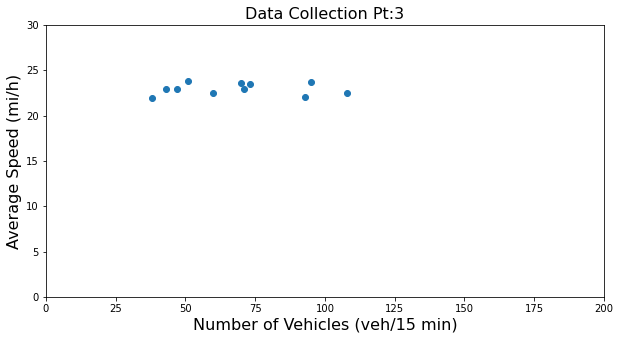

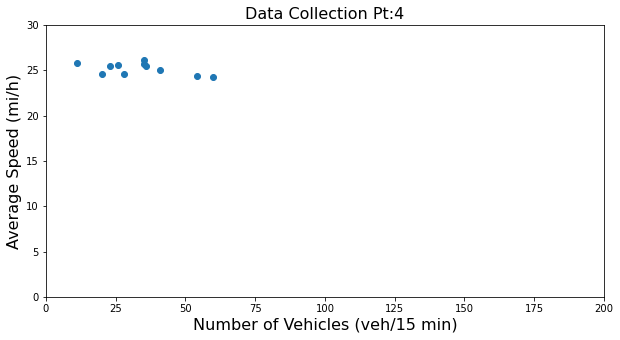

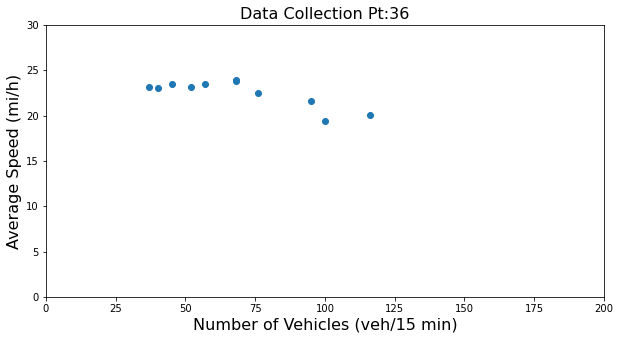

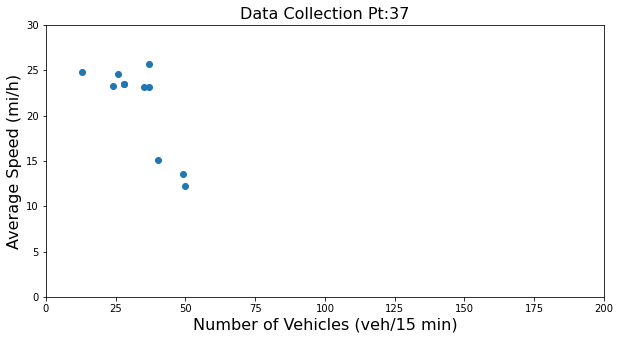

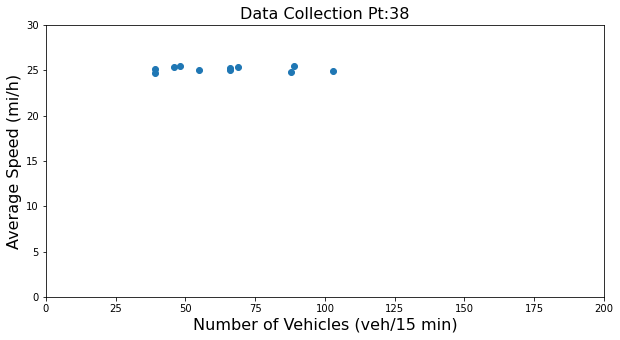

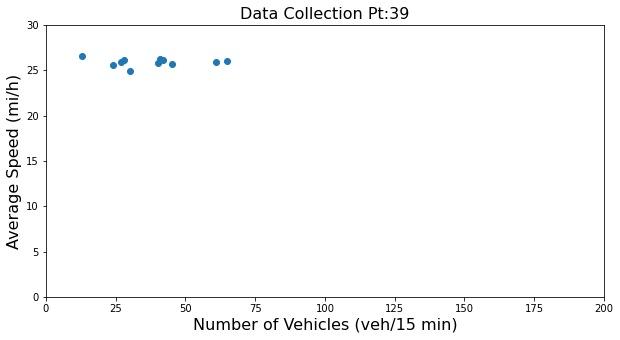

In [15]:
# Blockface 1
# plot
# List of data collection points
data_col = [3,4,36,37,38,39]

i=0
for dataf in [p30]:
    if dataf.name == 'p0':
        print('Parking rate = 0%')
    elif dataf.name == 'p30':
        print('Parking rate = 30%')
    else:
        print('Parking rate = 60%')
    i=i+1
    df = dataf.copy()
    # time intervals as bins
    bins = np.arange(0, 180, 15)
    labels = np.arange(11)
    
    df['binned'] = pd.cut(df['Time'], bins=bins, labels=labels)
    df['Speed_veh']=df['Speed']*df['No_Veh']


    df_g = df.groupby(['binned', 'Data_Measurement', 'Sim_Run']).agg({'No_Veh': 'sum',
                                                              'Speed_veh':'sum'})
    df=df_g.reset_index()
    df['Speed_avg']=df['Speed_veh']/df['No_Veh']
   # print(df)
    # Iterate through the five airlines
    for dc in data_col:
        # Subset to the airline
        subset = df[df['Data_Measurement'] == dc]
        #print(subset)
        f, ax = plt.subplots(1, sharex='col', figsize=(10, 5))
        
        scatter= ax.scatter( subset.No_Veh, subset.Speed_avg, cmap='jet')

        
        ax.set_xlabel('Number of Vehicles (veh/15 min)', size =16)
        ax.set_ylabel('Average Speed (mi/h)', size =16)
        ax.set_title('Data Collection Pt:{}'.format(dc), size =16)
        ax.set_ylim(0, 30)
        ax.set_xlim(0, 200)
        plt.show()

produce more simulation runs to have more data points in the diagrams